Unsupervised learning to explore PLGA clusters 
---

We apply an unsupervised learning scheme to investigate the time evolution of self-assembly pathways of the polymer chains.

## Libraries

In [50]:
import os   
import mdtraj
import hdbscan
import ase

import numpy as np 
import matplotlib.pyplot as plt  
import pandas as pd  
from ase.data import chemical_symbols
from ase.io import write

## Set figure style

In [4]:
plt.style.use('figure_style.mplstyle')

## [HDBSCAN* algorithm](https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html) <a name="S1"></a> 

### Loading trajectories <a name="S1.1"></a> 

At the end of the self-assembly simulations, save the trajectory of the AuNP and PLGAs using [`gmx trjconv`](https://manual.gromacs.org/documentation/5.1/onlinehelp/gmx-trjconv.html)
> **NOTE**: we show the analysis for the configuration with 60 PLGAs, but for the others it will be enough to change the trajectory and the number of PLGA as the hyperparameters used are the same.

In [24]:
dir_sim = '../simulations/1-PLGA_self-assembly/60/MD'
traj_path = os.path.join(dir_sim, 'traj_nowater.xtc')
gro_path = os.path.join(dir_sim, 'top_nowater.gro')
print(f'trj: {traj_path}, top: {gro_path}')

trj: ../simulations/1-PLGA_self-assembly/60/MD/traj_nowater.xtc, top: ../simulations/1-PLGA_self-assembly/60/MD/top_nowater.gro


In [25]:
traj = mdtraj.load_xtc(traj_path , top=gro_path)

### Clustering analysis <a name="S1.2"></a> 

In [31]:
all_frame = []
n_gold = 1925
n_clust_per_frame = np.zeros(len(traj))
for i_frame in range(0,len(traj),50):
    positions_plga = traj.xyz[i_frame, n_gold:, :]
    positions_plga = positions_plga - positions_plga.mean(axis=0)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=60, min_samples=7, metric='manhattan', cluster_selection_method='leaf', prediction_data=True).fit(positions_plga)
    n_clust_per_frame[i_frame] = clusterer.labels_.max()+1

Save the data

In [35]:
time_ns = np.arange(0,len(traj)*10/1000,50*10/1000)
n_clust = n_clust_per_frame[n_clust_per_frame>0]
t_ns = len(time_ns)
columns = ['time'] + ['n_clusters'] + ['mov_averg'] + ['ewm_averg']
N_variables = len(columns)
postp_df = pd.DataFrame(np.ones((t_ns, N_variables))*np.nan,
                   columns=columns)
postp_df.head()

,time,n_clusters,mov_averg,ewm_averg
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


> We computed two types of moving averages using [`pandas` function](https://pandas.pydata.org/docs/reference/frame.html#) to evaluate the most suitable for our analysis, namely [exponential weighted (EM) functions](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html).

In [37]:
mov_average = postp_df['n_clusters'].rolling(10, min_periods=1).mean()
ewm_average = np.round(postp_df['n_clusters'].ewm(alpha=0.25, adjust=False).mean())

In [38]:
postp_df.loc[:, 'time'] = time_ns
postp_df.loc[:, 'n_clusters'] = n_clust
postp_df.loc[:, 'mov_averg'] = mov_average
postp_df.loc[:, 'ewm_averg'] = ewm_average

In [39]:
postp_df

,time,n_clusters,mov_averg,ewm_averg
0,0.0,48.0,48.000000,48.0
1,0.5,43.0,45.500000,47.0
2,1.0,39.0,43.333333,45.0
3,1.5,37.0,41.750000,43.0
4,2.0,35.0,40.400000,41.0
...,...,...,...,...
196,98.0,12.0,10.100000,11.0
197,98.5,7.0,9.900000,10.0
198,99.0,11.0,10.100000,10.0
199,99.5,10.0,10.300000,10.0


### Plot the results <a name="S1.3"></a> 

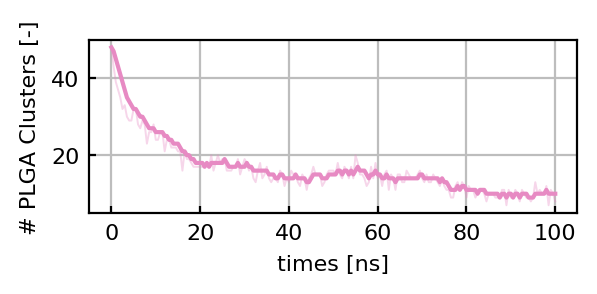

In [40]:
fig1 = plt.figure(1, figsize=(3.15,1.15), dpi=200)        
ax = fig1.add_subplot()                                               

ax.plot(postp_df['time'], postp_df['n_clusters'], ls = '-', color=plt.get_cmap('Set2')(3), alpha=0.35, lw=0.7)
ax.plot(postp_df['time'], postp_df['ewm_averg'], color=plt.get_cmap('Set2')(3), lw=1.5)

ax.set_xlabel('times [ns]')                                           
ax.set_ylabel('# PLGA Clusters [-]')                                  
plt.show()

### Save in pdb file for rendering analysis in VMD <a name="S1.4"></a> 

In [41]:
n_plga = 60                                                  #Remember to change for the other configurations
n_gold = 1925
plga_mask = np.arange(n_plga)
plga_mask = np.expand_dims(plga_mask, 1)
plga_mask = plga_mask.repeat(69, axis=1)                     #Note: 69 is the number of atoms forming one PLGA
plga_mask = np.concatenate(plga_mask)
plga_mask = plga_mask.astype('int32')
plga_mask

array([ 0,  0,  0, ..., 59, 59, 59], dtype=int32)

We save snapshots of the evolution of the clustering analysis at 0 ns, 20 ns and 100 ns.

In [42]:
time_sel = np.where(traj.time == 20000)[0][0]
n_frame = [0, time_sel, -1]

In [49]:
for i, frame_i in enumerate(n_frame):
    frame_t = traj.time[frame_i] * 1e-3
    box = traj.unitcell_vectors[frame_i]
    positions_plga = traj.xyz[frame_i, n_gold:, :]
    clusterer = hdbscan.HDBSCAN(min_cluster_size=60, min_samples=7, metric='manhattan', cluster_selection_method='leaf', prediction_data=True).fit(positions_plga)

    au_pos = traj.xyz[frame_i, :n_gold, :]
    au_name = [chemical_symbols[0]]*n_gold
    system = ase.Atoms(au_name, au_pos*10)
    clust_label = clusterer.labels_
    for cluster_id in range (0, clusterer.labels_.max()+1):
        atom_id_clust = np.where(clust_label == cluster_id)[0]
        plga_id_clust = np.unique(plga_mask[atom_id_clust])

        idx_atoms_clust = []
        for plga_id in plga_id_clust:
            idx_atoms_clust += np.where(plga_mask == plga_id)[0].tolist()
    
        idx_atoms_clust = np.array(idx_atoms_clust)
        clust_atom_pos = positions_plga[idx_atoms_clust]
        clust_atom_name = [chemical_symbols[cluster_id+2]]*len(idx_atoms_clust)
        clust_ase_atom = ase.Atoms(clust_atom_name, clust_atom_pos*10)
        system += clust_ase_atom

    system.set_cell(box*10)
    system.set_pbc(True)
    ase.io.write(f'clust60_frame_{frame_t}.pdb',system, 'proteindatabank')